# Patient Readmission Prediction Model 

### Develop a machine learning model to predict patient readmissions. By accurately identifying patients at risk of readmission, healthcare providers can implement targeted interventions to improve patient care and reduce costs.

## Benefits
### Improved Patient Care: Early identification of high-risk patients.
### Cost Reduction: Minimizing penalties associated with high readmission rates.
### Resource Optimization: Efficient allocation of healthcare resources.

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# XGBoost
from xgboost import XGBClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import shap
import shap


In [4]:
# Here we will load and describe the dataset 
ra_df = pd.read_csv('/Users/danielharrod/Medical_Data_Projects/Medical_Data_Projects/Healthcare_CSV/train.csv')

ra_df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000
mean,4.395640,42.96012,1.341080,15.988440,0.365920,0.203280,0.64300,7.420160,0.456400
std,2.991165,19.76881,1.705398,8.107743,1.224419,0.982973,1.26286,1.940932,0.498105
min,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,2.000000,31.00000,0.000000,10.000000,0.000000,0.000000,0.00000,6.000000,0.000000
50%,4.000000,44.00000,1.000000,15.000000,0.000000,0.000000,0.00000,8.000000,0.000000
75%,6.000000,57.00000,2.000000,20.000000,0.000000,0.000000,1.00000,9.000000,1.000000
max,14.000000,126.00000,6.000000,81.000000,36.000000,64.000000,21.00000,16.000000,1.000000


In [5]:
# List of expected columns
expected_columns = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
    'race_Caucasian', 'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
    'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?', 'payer_code_MC',
    'payer_code_HM', 'payer_code_SP', 'payer_code_BC', 'medical_specialty_?',
    'medical_specialty_InternalMedicine', 'medical_specialty_Emergency/Trauma',
    'medical_specialty_Family/GeneralPractice', 'medical_specialty_Cardiology', 'diag_1_428',
    'diag_1_414', 'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
    'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428', 'max_glu_serum_None',
    'A1Cresult_None', 'metformin_No', 'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
    'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No', 'tolbutamide_No',
    'pioglitazone_No', 'rosiglitazone_No', 'acarbose_No', 'miglitol_No', 'troglitazone_No',
    'tolazamide_No', 'examide_No', 'citoglipton_No', 'insulin_No', 'glyburide-metformin_No',
    'glipizide-metformin_No', 'glimepiride-pioglitazone_No', 'metformin-rosiglitazone_No',
    'metformin-pioglitazone_No', 'change_No', 'diabetesMed_Yes', 'readmitted'
]

# Check for missing columns
missing_columns = [col for col in expected_columns if col not in ra_df.columns]

if missing_columns:
    print(f"The following expected columns are missing from the dataset: {missing_columns}")
else:
    print("All expected columns are present in the dataset.")


All expected columns are present in the dataset.


In [6]:
# Identify the index positions
start_idx = ra_df.columns.get_loc('number_diagnoses') + 1
end_idx = ra_df.columns.get_loc('readmitted')

# Get the list of boolean columns
boolean_columns = ra_df.columns[start_idx:end_idx+1]

print("Boolean columns:")
print(boolean_columns.tolist())


Boolean columns:
['race_Caucasian', 'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)', 'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?', 'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC', 'medical_specialty_?', 'medical_specialty_InternalMedicine', 'medical_specialty_Emergency/Trauma', 'medical_specialty_Family/GeneralPractice', 'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414', 'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427', 'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428', 'max_glu_serum_None', 'A1Cresult_None', 'metformin_No', 'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No', 'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No', 'tolbutamide_No', 'pioglitazone_No', 'rosiglitazone_No', 'acarbose_No', 'miglitol_No', 'troglitazone_No', 'tolazamide_No', 'examide_No', 'citoglipton_No', 'insulin_No', 'glyburide-metformin_No', 'glipizide-metformin_No', 'glimepiride-pioglitazone_No', 

In [7]:
# Convert boolean columns to integers
ra_df[boolean_columns] = ra_df[boolean_columns].astype(int)


In [8]:
# Check data types
print("\nData types after conversion:")
print(ra_df[boolean_columns].dtypes)

# Display first few rows
ra_df[boolean_columns].head()



Data types after conversion:
race_Caucasian                              int64
race_AfricanAmerican                        int64
gender_Female                               int64
age_[70-80)                                 int64
age_[60-70)                                 int64
age_[50-60)                                 int64
age_[80-90)                                 int64
age_[40-50)                                 int64
payer_code_?                                int64
payer_code_MC                               int64
payer_code_HM                               int64
payer_code_SP                               int64
payer_code_BC                               int64
medical_specialty_?                         int64
medical_specialty_InternalMedicine          int64
medical_specialty_Emergency/Trauma          int64
medical_specialty_Family/GeneralPractice    int64
medical_specialty_Cardiology                int64
diag_1_428                                  int64
diag_1_414          

,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,...,citoglipton_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_No,diabetesMed_Yes,readmitted
0,1,0,0,0,0,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,1,0,1,0,0,1,0,0,0,0,...,1,0,1,1,1,1,1,0,1,1
2,1,0,1,0,0,0,1,0,0,1,...,1,1,1,1,1,1,1,1,1,1
3,1,0,1,0,0,1,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
4,1,0,1,0,0,0,1,0,1,0,...,1,1,1,1,1,1,1,1,0,0


In [9]:
# Check for missing values in the entire DataFrame
missing_values = ra_df.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    print("Columns with missing values:")
    print(missing_values)
else:
    print("No missing values detected in the dataset.")


No missing values detected in the dataset.


In [10]:
# Separate features and target variable
X = ra_df.drop('readmitted', axis=1)
y = ra_df['readmitted']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (25000, 64)
Target shape: (25000,)


In [11]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (20000, 64)
Testing set shape: (5000, 64)


In [12]:
# Function to clean feature names by removing invalid characters
def clean_feature_names(columns):
    cleaned_columns = []
    for col in columns:
        cleaned_col = col.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace('/', '_').replace(' ', '_').replace('-', '_').replace('?', 'missing')
        cleaned_columns.append(cleaned_col)
    return cleaned_columns

# Clean column names for training and testing sets
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

X_train_clean.columns = clean_feature_names(X_train_clean.columns)
X_test_clean.columns = clean_feature_names(X_test_clean.columns)

# Verify the cleaned column names
print("Cleaned Training Feature Names:")
print(X_train_clean.columns.tolist())

print("\nCleaned Testing Feature Names:")
print(X_test_clean.columns.tolist())


Cleaned Training Feature Names:
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'race_Caucasian', 'race_AfricanAmerican', 'gender_Female', 'age_70_80)', 'age_60_70)', 'age_50_60)', 'age_80_90)', 'age_40_50)', 'payer_code_missing', 'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC', 'medical_specialty_missing', 'medical_specialty_InternalMedicine', 'medical_specialty_Emergency_Trauma', 'medical_specialty_Family_GeneralPractice', 'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414', 'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427', 'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428', 'max_glu_serum_None', 'A1Cresult_None', 'metformin_No', 'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No', 'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No', 'tolbutamide_No', 'pioglitazone_No', 'rosiglitazone_No', 'acarbose_No'

In [13]:
# Define invalid characters
invalid_chars = ['[', ']', '<', '>', '/']

# Function to check for invalid characters
def check_invalid_chars(columns, invalid_chars):
    for col in columns:
        for char in invalid_chars:
            if char in col:
                print(f"Invalid character '{char}' found in column name: {col}")

# Check in training set
check_invalid_chars(X_train_clean.columns, invalid_chars)

# Check in testing set
check_invalid_chars(X_test_clean.columns, invalid_chars)



In [14]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    use_label_encoder=False,  # Suppress warnings related to label encoding
    eval_metric='logloss',    # Specify evaluation metric
    random_state=42
)

# Train the model using the cleaned training data
xgb_model.fit(X_train_clean, y_train)

print("XGBoost Model Training Completed Successfully!")


XGBoost Model Training Completed Successfully!


In [15]:
# Predict the labels for the test set
y_pred = xgb_model.predict(X_test_clean)

# Predict the probabilities for the test set
y_pred_proba = xgb_model.predict_proba(X_test_clean)[:, 1]


In [16]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

# Calculate ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')


Accuracy: 0.6164
Precision: 0.5906
Recall: 0.5197
F1 Score: 0.5529
ROC AUC Score: 0.6504


In [17]:
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.70      0.66      2718
           1       0.59      0.52      0.55      2282

    accuracy                           0.62      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.62      0.61      5000



In [18]:
# Initialize JavaScript visualization for SHAP (only necessary in Jupyter notebooks)
shap.initjs()

# Create a TreeExplainer object
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_clean)



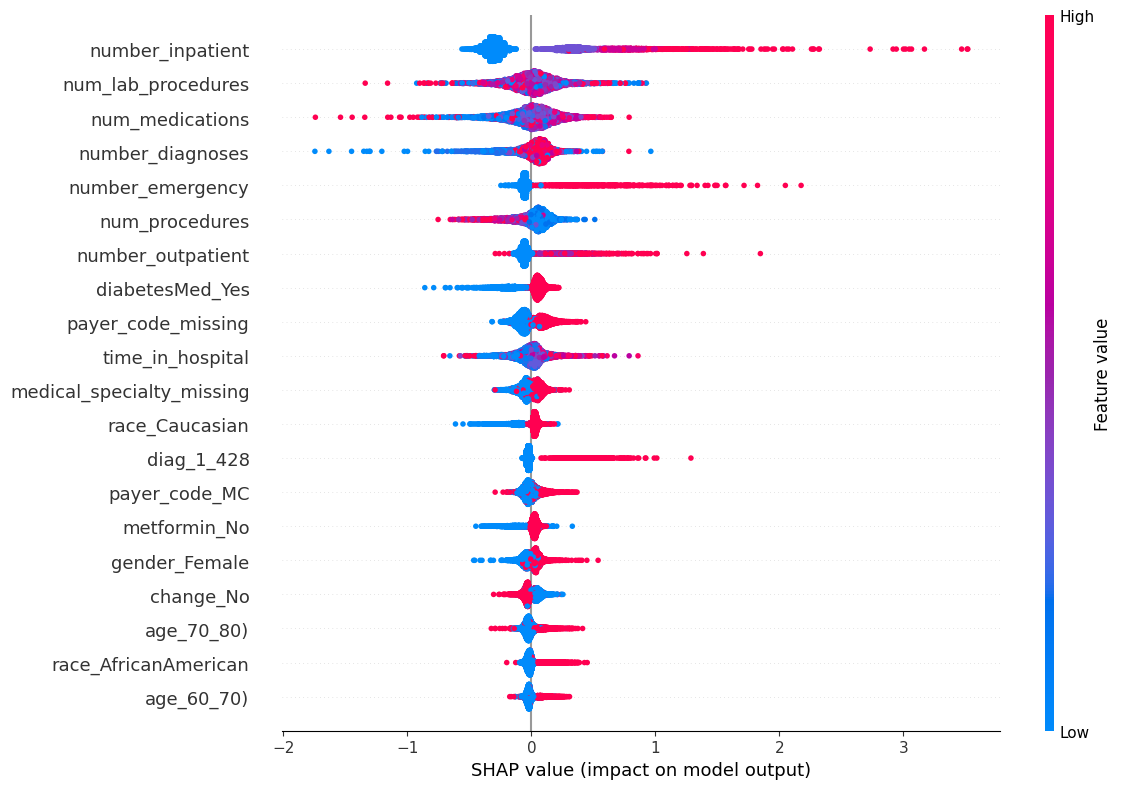

In [19]:
# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_clean, plot_size=(12, 8))


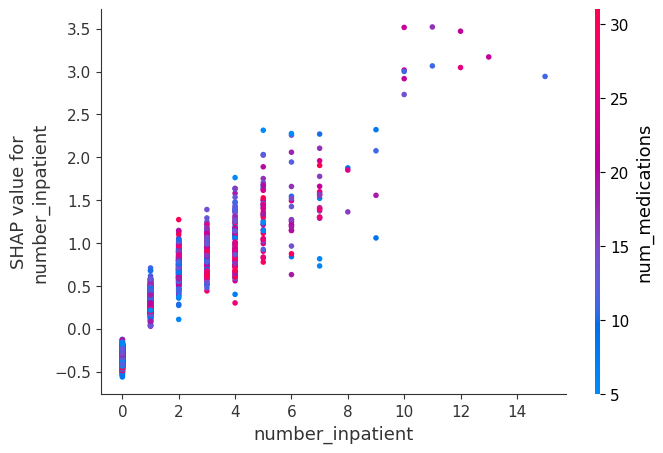

In [20]:
shap.dependence_plot(
    "number_inpatient", shap_values, X_test_clean, interaction_index="num_medications"
)


In [21]:
# Create a SHAP scatter plot for number_inpatient
shap.plots.scatter(shap_values[:, "number_inpatient"], color=shap_values)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [46]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_clean.iloc[0,:])


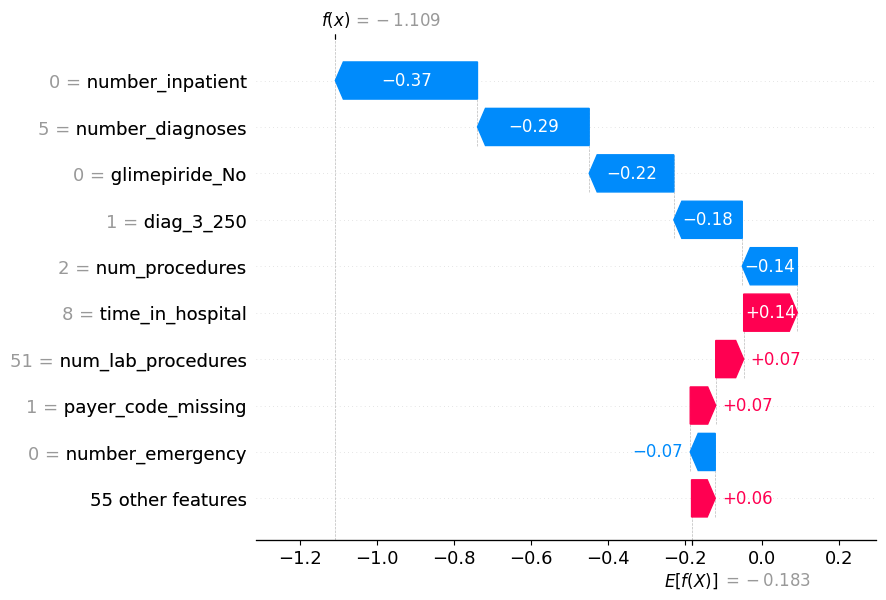

In [25]:
# Step 1: Calculate SHAP values (assuming you have already trained an XGBoost model)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_clean)

# Step 2: Create an Explanation object
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_test_clean)

# Step 3: Generate the waterfall plot for the first observation
shap.waterfall_plot(explanation[0])


In [27]:
shap_interaction_values = explainer.shap_interaction_values(X_test_clean)

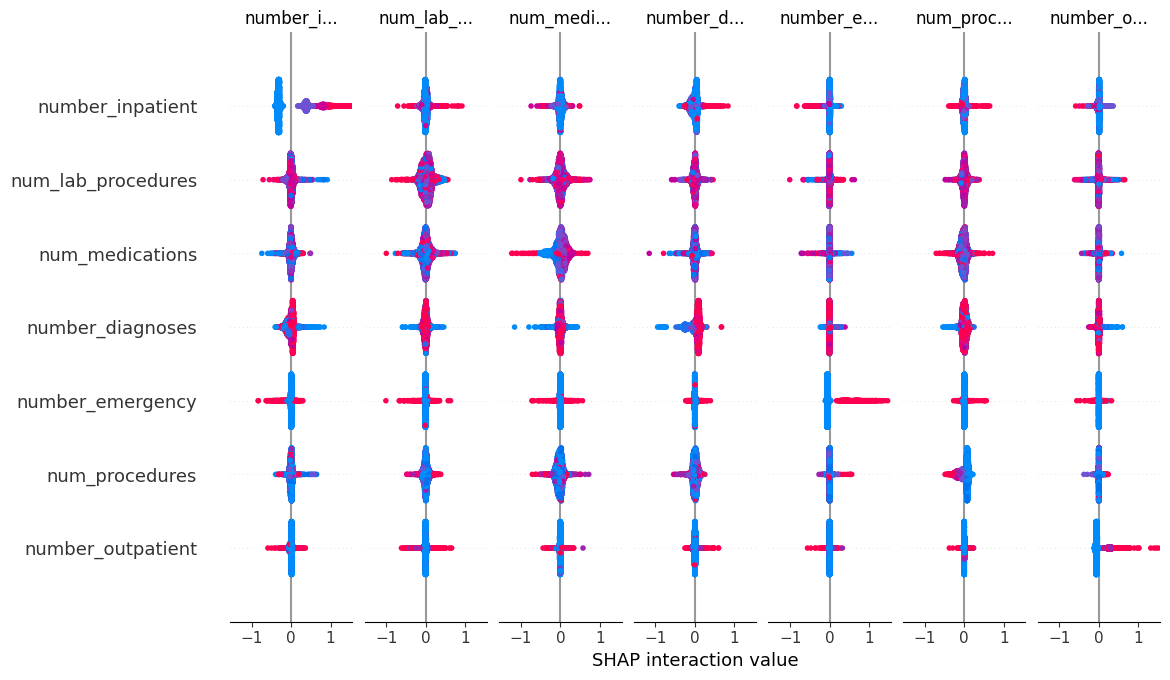

In [28]:
shap.summary_plot(shap_interaction_values, X_test_clean)